In [1]:
%pip install transformers==4.40.2 peft==0.11.1 accelerate==0.30.1 datasets seaborn matplotlib scikit-learn openpyxl sentencepiece -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Model Experiment: AlBERT.ipynb

# AlBERT for Hindi Poem Emotion Classification

**Model:** `albert-base-v2`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Load Dataset
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/2.xlsx'
    print('Running on Google Colab.')
except ModuleNotFoundError:
    # Fallback to local paths if not on colab
    file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
    print('Running locally.')

print(f"Using dataset path: {file_path}")

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    # Make sure we use dominant_category
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found. Please check the file path.")

Running locally.
Using dataset path: ../Final_hindi_dataset_with_emotions_categorized.xlsx
Loaded 1600 samples, 10 classes


In [5]:
model_name = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [7]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_albert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.051748275756836, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 5.2773, 'eval_samples_per_second': 60.637, 'eval_steps_per_second': 1.895, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0534071922302246, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.4047, 'eval_samples_per_second': 93.988, 'eval_steps_per_second': 2.937, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0430946350097656, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.2701, 'eval_samples_per_second': 97.858, 'eval_steps_per_second': 3.058, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0497257709503174, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.0532, 'eval_samples_per_second': 104.809, 'eval_steps_per_second': 3.275, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0575451850891113, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.2082, 'eval_samples_per_second': 99.744, 'eval_steps_per_second': 3.117, 'epoch': 5.0}
{'train_runtime': 215.984, 'train_samples_per_second': 29.632, 'train_steps_per_second': 1.852, 'train_loss': 2.08891357421875, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.08891357421875, metrics={'train_runtime': 215.984, 'train_samples_per_second': 29.632, 'train_steps_per_second': 1.852, 'total_flos': 27205588300800.0, 'train_loss': 2.08891357421875, 'epoch': 5.0})

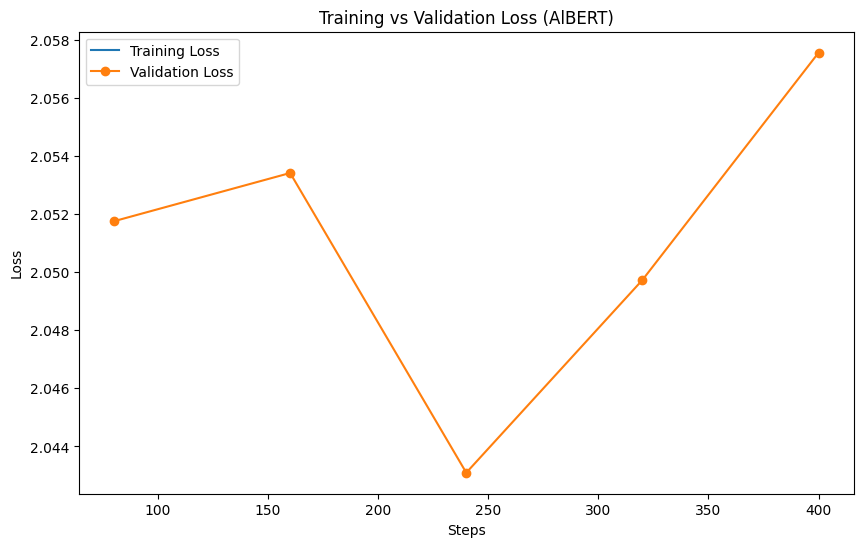

In [8]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (AlBERT)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

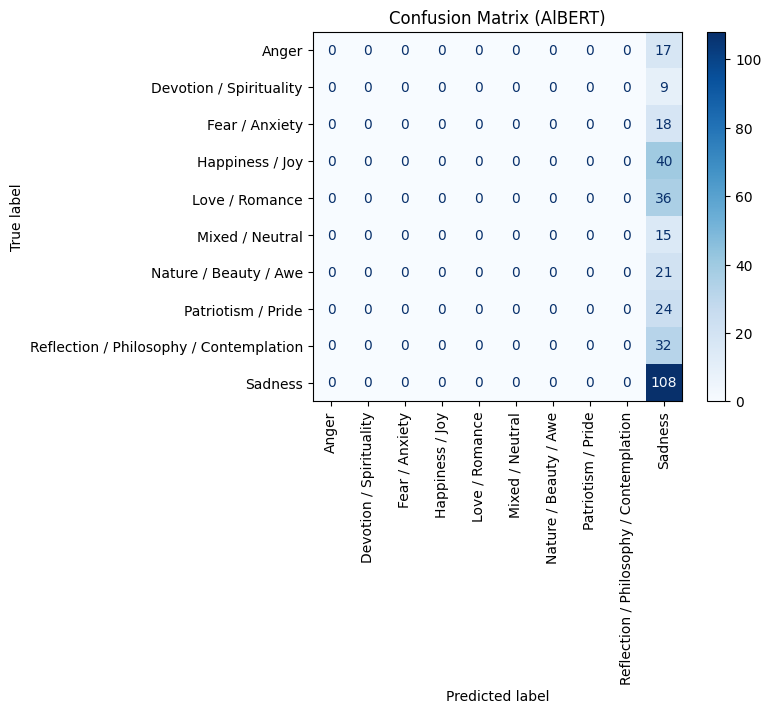

In [9]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (AlBERT)')
plt.show()

In [10]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: BERT.ipynb

# BERT for Hindi Poem Emotion Classification

This notebook implements BERT for classifying emotions in Hindi poems using the `Final_hindi_dataset_with_emotions_categorized.xlsx` dataset.

**Features:**
- Uses `bert-base-multilingual-cased` (better for Hindi than standard BERT)
- GPU acceleration specific handling
- Visualizations: Confusion Matrix, Training vs Validation Loss


In [11]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Load Dataset
# Try loading from local relative path, else assume Colab upload
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx' # Fallback for Colab if uploaded to root

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
else:
    print(f"Dataset not found at {file_path}. Please upload 'Final_hindi_dataset_with_emotions_categorized.xlsx'.")

# Display first few rows
df.head()

Dataset loaded successfully.


,poem_text,hindi_description,english_description,author,dominant_category,secondary_category,contextual_clue,dominant_emotion,secondary_emotion
0,आकांक्षा~स्त्रीनिचोड़ देती हैबूँद-बूँद रक्तफिर...,यह कविता एक स्त्री की आकांक्षाओं को दर्शाती है...,This poem depicts the aspirations of a woman w...,रंजना जायसवाल,Sadness,Sadness,dreams do not become green,Disillusionment,Pain
1,हार जीत~रिश्तों रवायतों की जंगकहाँ आसान हैअपनो...,यह कविता रिश्तों और रवायतों की जंग को आसान नही...,This poem does not describe the war of relatio...,देवी नांगरानी,Sadness,Love / Romance,own defeat in loved ones' loss,Sorrow,Empathy
2,ज़िन्दगी~पैबन्द-दर-पैबन्दफटी हुई पतलूनफिर भीटा...,यह कविता ज़िन्दगी को पैबन्द-दर-पैबन्द फटी हुई ...,This poem describes life as patched-up torn pa...,प्रताप सहगल,Patriotism / Pride,Patriotism / Pride,passion to hold onto life,Determination,Resilience
3,मरीचिका~पीवण नै ना सहीदेखण नै तो हैधोरां मांय ...,यह कविता राजस्थानी भाषा में है। इसमें मरीचिका ...,This poem is in the Rajasthani language. It de...,नीरज दइया,Nature / Beauty / Awe,Sadness,"mirage visible, not for drinking",Wonder,Longing
4,अपनी आवाज़ ने~अपनी आवाज़ ने बतायाकितनी दूर निक...,यह कविता अपनी आवाज़ से पता चलने वाली दूरी और न...,This poem speaks of the distance and desolatio...,मनमोहन,Sadness,Reflection / Philosophy / Contemplation,own voice reveals desolation,Loneliness,Introspection


In [13]:
# Preprocessing
# Drop NaN values in text or label
df = df.dropna(subset=['poem_text', 'dominant_category'])
df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)

texts = df['poem_text'].tolist()
labels_raw = df['dominant_category'].tolist()

# Encode Labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_raw)
num_labels = len(label_encoder.classes_)
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {num_labels}")

Classes: ['Anger' 'Devotion / Spirituality' 'Fear / Anxiety' 'Happiness / Joy'
 'Love / Romance' 'Mixed / Neutral' 'Nature / Beauty / Awe'
 'Patriotism / Pride' 'Reflection / Philosophy / Contemplation' 'Sadness']
Number of classes: 10


In [14]:
# Tokenizer (Multilingual BERT for Hindi)
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize Data
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Split Data
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_encodings = {'input_ids': train_inputs, 'attention_mask': train_masks}
val_encodings = {'input_ids': val_inputs, 'attention_mask': val_masks}

train_dataset = PoemDataset(train_encodings, train_labels)
val_dataset = PoemDataset(val_encodings, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [16]:
# Metrics Calculation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [17]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,              # Increased epochs for better convergence
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none" # Disable wandb/mlflow for local/colab simplicity unless requested
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

{'loss': 2.3181, 'grad_norm': 11.271974563598633, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.12}
{'loss': 2.2932, 'grad_norm': 3.6921563148498535, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.25}
{'loss': 2.2692, 'grad_norm': 4.258155345916748, 'learning_rate': 3e-06, 'epoch': 0.38}
{'loss': 2.2234, 'grad_norm': 5.915215015411377, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5}
{'loss': 2.1162, 'grad_norm': 5.228924751281738, 'learning_rate': 5e-06, 'epoch': 0.62}
{'loss': 2.121, 'grad_norm': 4.926390647888184, 'learning_rate': 6e-06, 'epoch': 0.75}
{'loss': 2.1047, 'grad_norm': 4.722002029418945, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.88}
{'loss': 1.9924, 'grad_norm': 4.155513763427734, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0258636474609375, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.2552, 'eval_samples_per_second': 98.303, 'eval_steps_per_second': 3.072, 'epoch': 1.0}
{'loss': 2.0817, 'grad_norm': 4.321351051330566, 'learning_rate': 9e-06, 'epoch': 1.12}
{'loss': 2.0746, 'grad_norm': 4.788991928100586, 'learning_rate': 1e-05, 'epoch': 1.25}
{'loss': 1.9685, 'grad_norm': 3.9860098361968994, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.38}
{'loss': 2.0963, 'grad_norm': 5.944462776184082, 'learning_rate': 1.2e-05, 'epoch': 1.5}
{'loss': 2.0661, 'grad_norm': 3.5754194259643555, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.62}
{'loss': 2.091, 'grad_norm': 3.337230682373047, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.75}
{'loss': 1.9836, 'grad_norm': 5.9442267417907715, 'learning_rate': 1.5e-05, 'epoch': 1.88}
{'loss': 1.8291, 'grad_norm': 5.696481704711914, 'learning_rate': 1.600

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9804435968399048, 'eval_accuracy': 0.38125, 'eval_f1': 0.23446969696969697, 'eval_precision': 0.183984375, 'eval_recall': 0.38125, 'eval_runtime': 3.1962, 'eval_samples_per_second': 100.118, 'eval_steps_per_second': 3.129, 'epoch': 2.0}
{'loss': 1.9467, 'grad_norm': 8.040637016296387, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.12}
{'loss': 2.0036, 'grad_norm': 6.240766525268555, 'learning_rate': 1.8e-05, 'epoch': 2.25}
{'loss': 1.9839, 'grad_norm': 4.270373821258545, 'learning_rate': 1.9e-05, 'epoch': 2.38}
{'loss': 1.9968, 'grad_norm': 14.957062721252441, 'learning_rate': 2e-05, 'epoch': 2.5}
{'loss': 1.9643, 'grad_norm': 11.395796775817871, 'learning_rate': 2.1e-05, 'epoch': 2.62}
{'loss': 1.9202, 'grad_norm': 8.748038291931152, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.75}
{'loss': 1.9509, 'grad_norm': 4.977270603179932, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.88}
{'loss': 1.9461, 'grad_norm': 6.915759086608887, 'learning_rate': 2.4e-05

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9738258123397827, 'eval_accuracy': 0.371875, 'eval_f1': 0.2395284947610529, 'eval_precision': 0.24619565217391304, 'eval_recall': 0.371875, 'eval_runtime': 3.2511, 'eval_samples_per_second': 98.428, 'eval_steps_per_second': 3.076, 'epoch': 3.0}
{'loss': 1.7102, 'grad_norm': 5.6089067459106445, 'learning_rate': 2.5e-05, 'epoch': 3.12}
{'loss': 1.876, 'grad_norm': 6.0819196701049805, 'learning_rate': 2.6000000000000002e-05, 'epoch': 3.25}
{'loss': 1.8508, 'grad_norm': 6.807828426361084, 'learning_rate': 2.7000000000000002e-05, 'epoch': 3.38}
{'loss': 1.8866, 'grad_norm': 10.6610107421875, 'learning_rate': 2.8000000000000003e-05, 'epoch': 3.5}
{'loss': 1.9463, 'grad_norm': 9.776483535766602, 'learning_rate': 2.9e-05, 'epoch': 3.62}
{'loss': 1.8525, 'grad_norm': 8.343015670776367, 'learning_rate': 3e-05, 'epoch': 3.75}
{'loss': 1.8184, 'grad_norm': 13.288045883178711, 'learning_rate': 3.1e-05, 'epoch': 3.88}
{'loss': 1.9004, 'grad_norm': 8.828238487243652, 'learning_rate': 

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9616596698760986, 'eval_accuracy': 0.36875, 'eval_f1': 0.2540678717393917, 'eval_precision': 0.23255394224529527, 'eval_recall': 0.36875, 'eval_runtime': 3.1984, 'eval_samples_per_second': 100.051, 'eval_steps_per_second': 3.127, 'epoch': 4.0}
{'loss': 1.7288, 'grad_norm': 9.071762084960938, 'learning_rate': 3.3e-05, 'epoch': 4.12}
{'loss': 1.6531, 'grad_norm': 14.300093650817871, 'learning_rate': 3.4000000000000007e-05, 'epoch': 4.25}
{'loss': 1.4846, 'grad_norm': 10.893250465393066, 'learning_rate': 3.5e-05, 'epoch': 4.38}
{'loss': 1.6081, 'grad_norm': 13.721331596374512, 'learning_rate': 3.6e-05, 'epoch': 4.5}
{'loss': 1.5241, 'grad_norm': 13.491548538208008, 'learning_rate': 3.7e-05, 'epoch': 4.62}
{'loss': 1.5807, 'grad_norm': 13.486189842224121, 'learning_rate': 3.8e-05, 'epoch': 4.75}
{'loss': 1.8163, 'grad_norm': 13.823746681213379, 'learning_rate': 3.9000000000000006e-05, 'epoch': 4.88}
{'loss': 1.8019, 'grad_norm': 12.351272583007812, 'learning_rate': 4e-05, '

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9928271770477295, 'eval_accuracy': 0.315625, 'eval_f1': 0.27870517581734067, 'eval_precision': 0.267003627649507, 'eval_recall': 0.315625, 'eval_runtime': 3.2309, 'eval_samples_per_second': 99.044, 'eval_steps_per_second': 3.095, 'epoch': 5.0}
{'train_runtime': 300.5379, 'train_samples_per_second': 21.295, 'train_steps_per_second': 1.331, 'train_loss': 1.9345108628273011, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=1.9345108628273011, metrics={'train_runtime': 300.5379, 'train_samples_per_second': 21.295, 'train_steps_per_second': 1.331, 'total_flos': 384827558169600.0, 'train_loss': 1.9345108628273011, 'epoch': 5.0})

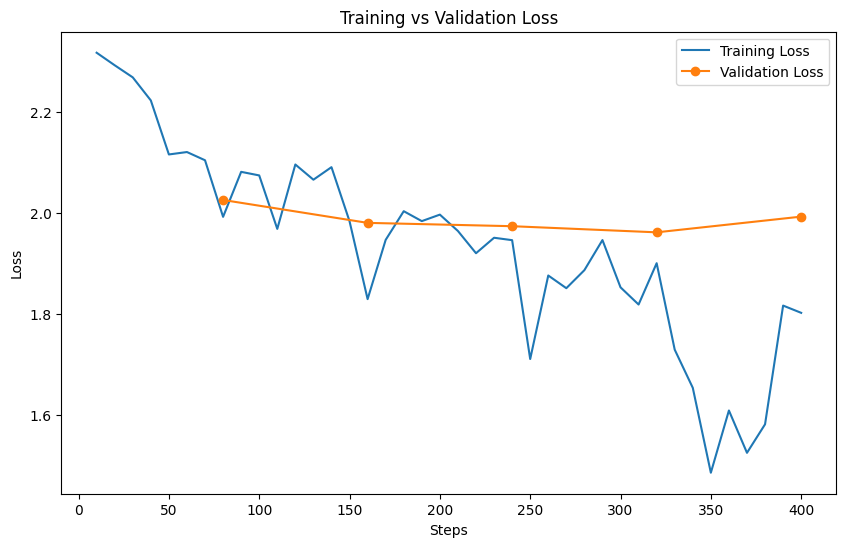

In [18]:
# Visualization: Training vs Validation Loss
log_history = trainer.state.log_history
epochs = []
train_loss = []
eval_loss = []

# Extract loss values
for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        # Some entries might be fractional epochs, we take the latest for plotting or smoothen
        pass
    if 'eval_loss' in entry:
        epochs.append(entry['epoch'])
        eval_loss.append(entry['eval_loss'])
        # Find corresponding training loss (approximate or valid step)
        # For simplicity in this logic, we might need a better extraction if steps don't align perfectly,
        # but usually 'loss' is logged frequently. Let's just plot available points.

# Better separate extraction
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

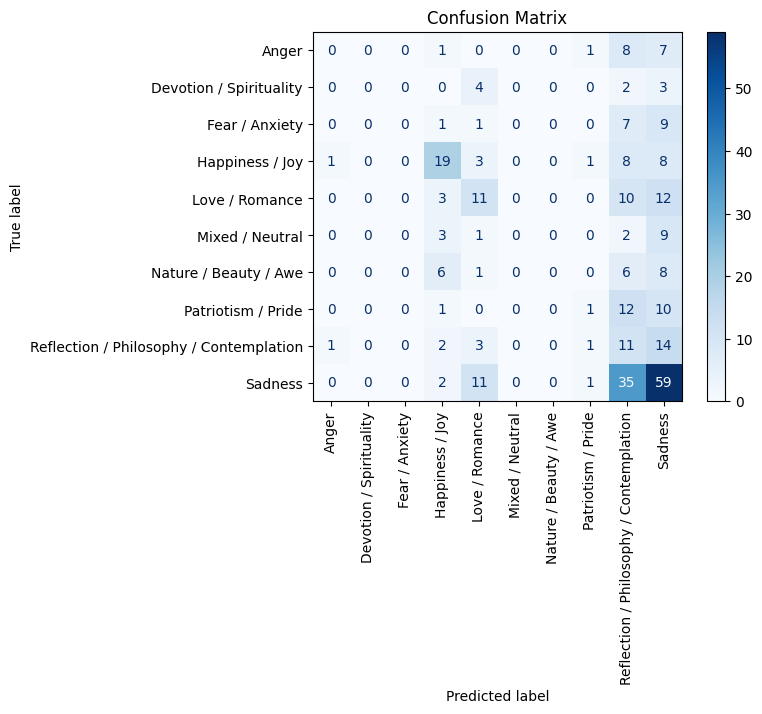

In [19]:
# Visualization: Confusion Matrix
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Save Model
model_path = "./bert_hindi_emotion_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

Model saved to ./bert_hindi_emotion_model


In [21]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: BERT_CNN_BLSTM.ipynb

# BERT + CNN + BiLSTM for Hindi Poem Emotion Classification

This notebook implements a hybrid model combining BERT (for embeddings) with CNN and BiLSTM (for sequence modeling) to classify emotions in Hindi poems.

**Architecture:**
- **Embedding Layer:** `bert-base-multilingual-cased`
- **Feature Extraction:** 1D Convolution + Max Pooling
- **Sequence Modeling:** Bidirectional LSTM
- **Classification:** Dense Layer


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [23]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

Loaded 1600 samples, 10 classes


In [24]:
# Tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
# Hybrid Model Definition
class BertCnnLstm(nn.Module):
    def __init__(self, num_labels):
        super(BertCnnLstm, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        
        # CNN: (batch, hidden, seq_len) -> (batch, filters, seq_len)
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM: Input dim 128 (from CNN filters), Hidden 100
        self.lstm = nn.LSTM(input_size=128, hidden_size=100, num_layers=1, 
                            batch_first=True, bidirectional=True)
        
        # Classifier: 2 * hidden (bidirectional) -> num_labels
        self.classifier = nn.Linear(200, num_labels)
        
        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # BERT Output: (batch, seq_len, hidden)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        
        # Permute for CNN: (batch, hidden, seq_len)
        x = sequence_output.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Permute for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        
        # Global Max Pooling or Last State? typical is Last State or Max/Avg Pool
        # Using last hidden state of the sequence
        x = x[:, -1, :]
        
        x = self.dropout(x)
        logits = self.classifier(x)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return (loss, logits) if loss is not None else logits

In [26]:
# Initialize Model
model = BertCnnLstm(num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertCnnLstm(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [28]:
training_args = TrainingArguments(
    output_dir='./results_hybrid',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.1117007732391357, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.3714, 'eval_samples_per_second': 94.917, 'eval_steps_per_second': 2.966, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.041829824447632, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.3845, 'eval_samples_per_second': 94.549, 'eval_steps_per_second': 2.955, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0238356590270996, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.3504, 'eval_samples_per_second': 95.512, 'eval_steps_per_second': 2.985, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9857501983642578, 'eval_accuracy': 0.3875, 'eval_f1': 0.24096344086021504, 'eval_precision': 0.1786304854780581, 'eval_recall': 0.3875, 'eval_runtime': 3.3437, 'eval_samples_per_second': 95.703, 'eval_steps_per_second': 2.991, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.014993190765381, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.2954, 'eval_samples_per_second': 97.104, 'eval_steps_per_second': 3.035, 'epoch': 5.0}
{'train_runtime': 316.2171, 'train_samples_per_second': 20.239, 'train_steps_per_second': 1.265, 'train_loss': 2.081736602783203, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.081736602783203, metrics={'train_runtime': 316.2171, 'train_samples_per_second': 20.239, 'train_steps_per_second': 1.265, 'total_flos': 0.0, 'train_loss': 2.081736602783203, 'epoch': 5.0})

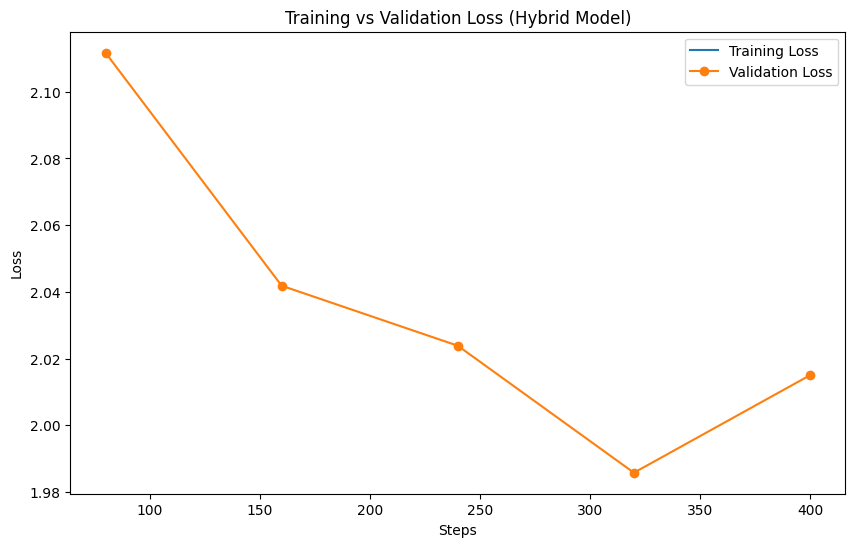

In [29]:
# Loss Visualization
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (Hybrid Model)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

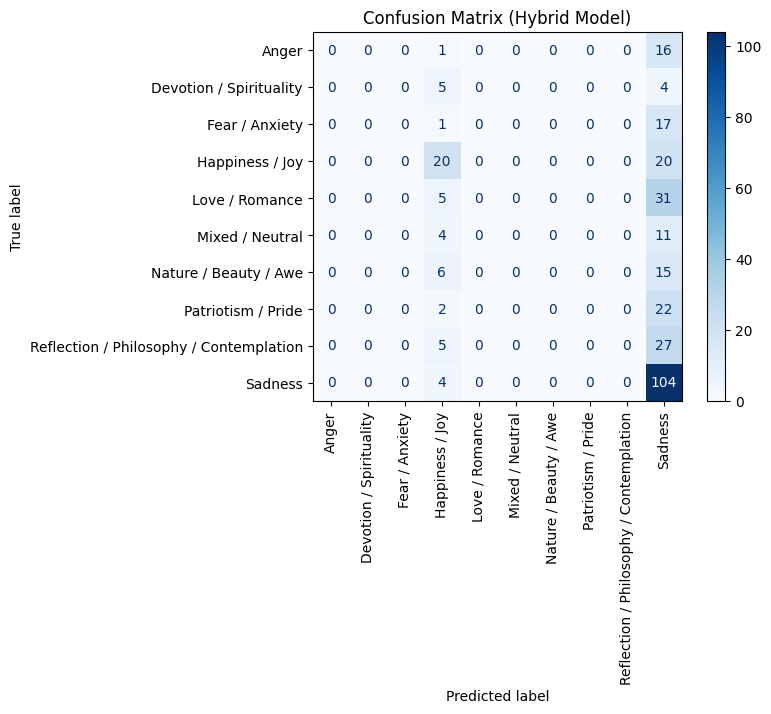

In [30]:
# Confusion Matrix
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Hybrid Model)')
plt.show()

In [31]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: BioBERT.ipynb

# BioBERT for Hindi Poem Emotion Classification

**Model:** `dmis-lab/biobert-v1.1`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [32]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [33]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

Loaded 1600 samples, 10 classes


In [34]:
model_name = 'dmis-lab/biobert-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [36]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_biobert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.026411533355713, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 3.6096, 'eval_samples_per_second': 88.653, 'eval_steps_per_second': 2.77, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.014178991317749, 'eval_accuracy': 0.34375, 'eval_f1': 0.20923444976076558, 'eval_precision': 0.1542126225490196, 'eval_recall': 0.34375, 'eval_runtime': 3.6338, 'eval_samples_per_second': 88.062, 'eval_steps_per_second': 2.752, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0428104400634766, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 4.271, 'eval_samples_per_second': 74.924, 'eval_steps_per_second': 2.341, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0308799743652344, 'eval_accuracy': 0.340625, 'eval_f1': 0.17682355629176902, 'eval_precision': 0.23926332288401256, 'eval_recall': 0.340625, 'eval_runtime': 4.3376, 'eval_samples_per_second': 73.774, 'eval_steps_per_second': 2.305, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0238184928894043, 'eval_accuracy': 0.35625, 'eval_f1': 0.22471544715447153, 'eval_precision': 0.16414518834833003, 'eval_recall': 0.35625, 'eval_runtime': 3.7859, 'eval_samples_per_second': 84.524, 'eval_steps_per_second': 2.641, 'epoch': 5.0}
{'train_runtime': 322.7988, 'train_samples_per_second': 19.827, 'train_steps_per_second': 1.239, 'train_loss': 2.0702194213867187, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.0702194213867187, metrics={'train_runtime': 322.7988, 'train_samples_per_second': 19.827, 'train_steps_per_second': 1.239, 'total_flos': 421007926886400.0, 'train_loss': 2.0702194213867187, 'epoch': 5.0})

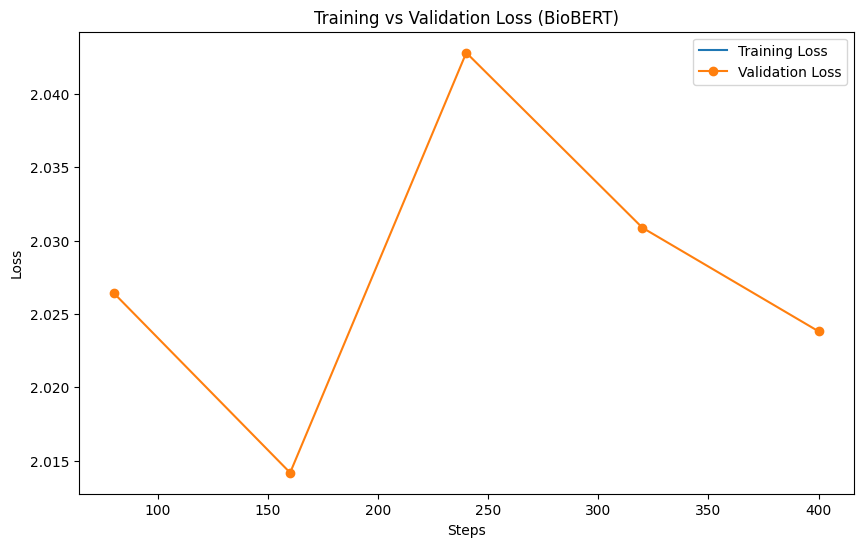

In [37]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (BioBERT)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

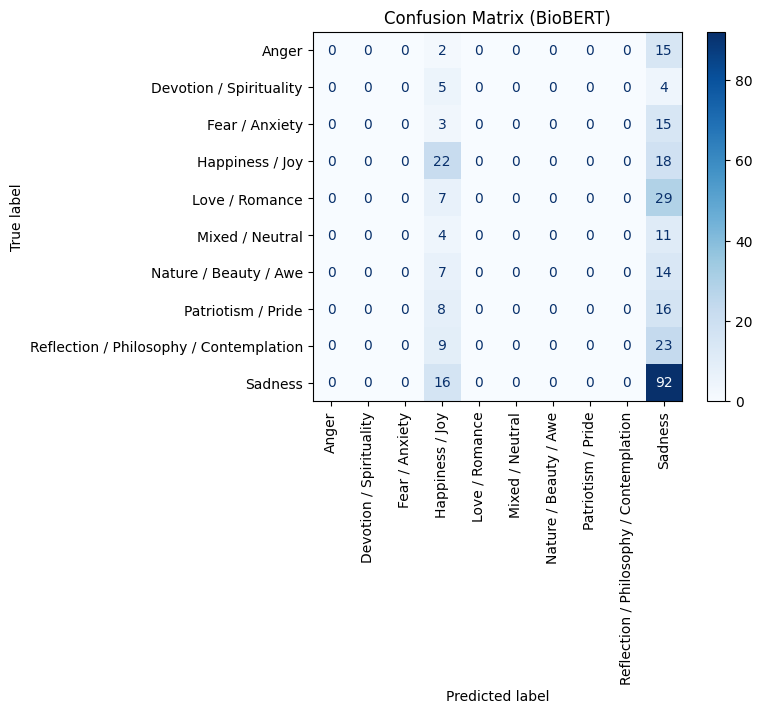

In [38]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (BioBERT)')
plt.show()

In [39]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: CNN_BLSTM.ipynb

# CNN + BiLSTM for Hindi Poem Emotion Classification

**Architecture:** Embedding (Scratch) -> CNN -> BiLSTM -> Dense
**Tokenizer:** BERT Tokenizer (used only for tokenizing, embeddings are trained from scratch)
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [40]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")
    texts = ["dummy"] * 10
    labels = [0] * 10
    num_labels = 1

Loaded 1600 samples, 10 classes


In [42]:
# Tokenizer (used for vocab)
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
vocab_size = tokenizer.vocab_size

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
# Model Definition
class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_labels):
        super(CNN_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        
        # CNN
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # BiLSTM
        self.lstm = nn.LSTM(input_size=128, hidden_size=100, num_layers=1, 
                            batch_first=True, bidirectional=True)
        
        self.classifier = nn.Linear(200, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids) # (batch, seq, dim)
        x = self.dropout(x)
        
        x = x.permute(0, 2, 1) # (batch, dim, seq)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.permute(0, 2, 1) # (batch, seq, dim)
        x, _ = self.lstm(x)
        
        x = x[:, -1, :]
        logits = self.classifier(x)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return (loss, logits) if loss is not None else logits

In [44]:
model = CNN_BiLSTM(vocab_size=vocab_size, embedding_dim=128, num_labels=num_labels)
model.to(device)

CNN_BiLSTM(
  (embedding): Embedding(119547, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 100, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=200, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [45]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_cnn_blstm',
    num_train_epochs=10, # More epochs for scratch training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.2699389457702637, 'eval_accuracy': 0.1, 'eval_f1': 0.01818181818181818, 'eval_precision': 0.01, 'eval_recall': 0.1, 'eval_runtime': 0.4032, 'eval_samples_per_second': 793.61, 'eval_steps_per_second': 24.8, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.19260835647583, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.096, 'eval_samples_per_second': 3333.683, 'eval_steps_per_second': 104.178, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.080549716949463, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0913, 'eval_samples_per_second': 3506.238, 'eval_steps_per_second': 109.57, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0481178760528564, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1448, 'eval_samples_per_second': 2209.196, 'eval_steps_per_second': 69.037, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0407261848449707, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1019, 'eval_samples_per_second': 3139.53, 'eval_steps_per_second': 98.11, 'epoch': 5.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0405590534210205, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1254, 'eval_samples_per_second': 2551.406, 'eval_steps_per_second': 79.731, 'epoch': 6.0}
{'loss': 2.1246, 'grad_norm': 0.9841585755348206, 'learning_rate': 5e-05, 'epoch': 6.25}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0394628047943115, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.2088, 'eval_samples_per_second': 1532.302, 'eval_steps_per_second': 47.884, 'epoch': 7.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0387954711914062, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.195, 'eval_samples_per_second': 1641.287, 'eval_steps_per_second': 51.29, 'epoch': 8.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0383527278900146, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1007, 'eval_samples_per_second': 3176.743, 'eval_steps_per_second': 99.273, 'epoch': 9.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0381486415863037, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0925, 'eval_samples_per_second': 3457.999, 'eval_steps_per_second': 108.062, 'epoch': 10.0}
{'train_runtime': 44.263, 'train_samples_per_second': 289.18, 'train_steps_per_second': 18.074, 'train_loss': 2.094260406494141, 'epoch': 10.0}


TrainOutput(global_step=800, training_loss=2.094260406494141, metrics={'train_runtime': 44.263, 'train_samples_per_second': 289.18, 'train_steps_per_second': 18.074, 'total_flos': 0.0, 'train_loss': 2.094260406494141, 'epoch': 10.0})

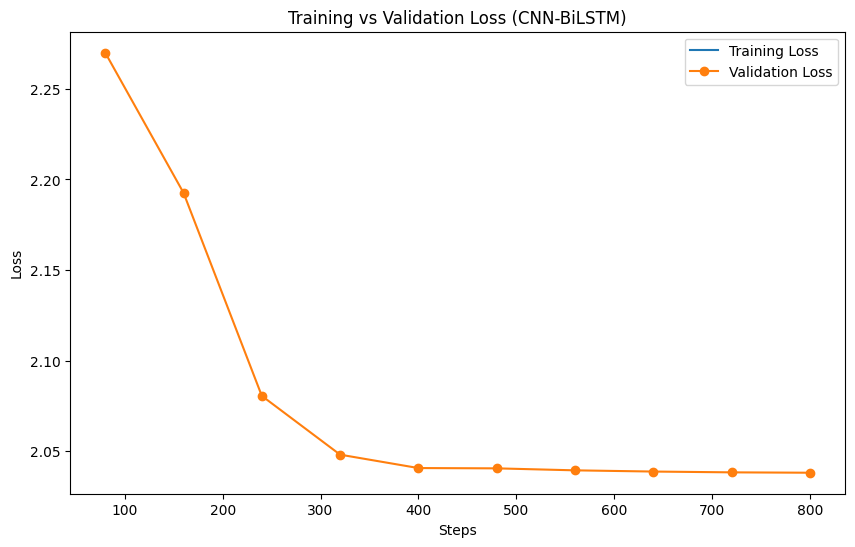

In [46]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (CNN-BiLSTM)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

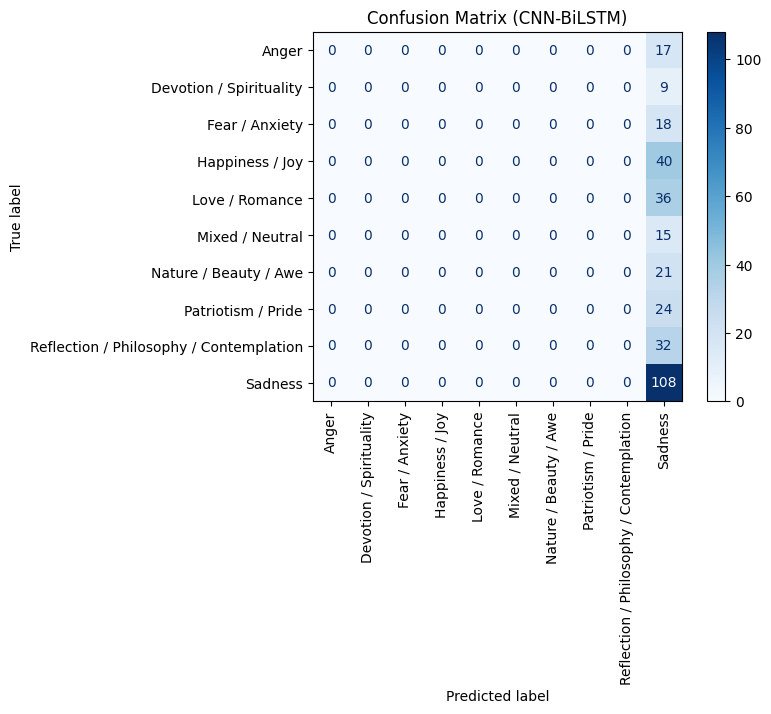

In [47]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (CNN-BiLSTM)')
plt.show()

In [48]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: CNN_LSTM.ipynb

# CNN + LSTM for Hindi Poem Emotion Classification

**Architecture:** Embedding (Scratch) -> CNN -> LSTM (Unidirectional) -> Dense
**Tokenizer:** BERT Tokenizer (used only for tokenizing, embeddings are trained from scratch)
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [50]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")
    texts = ["dummy"] * 10
    labels = [0] * 10
    num_labels = 1

Loaded 1600 samples, 10 classes


In [51]:
# Tokenizer (used for vocab)
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
vocab_size = tokenizer.vocab_size

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [52]:
# Model Definition
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_labels):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        
        # CNN
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM (Unidirectional)
        self.lstm = nn.LSTM(input_size=128, hidden_size=100, num_layers=1, 
                            batch_first=True, bidirectional=False)
        
        self.classifier = nn.Linear(100, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)
        x = self.dropout(x)
        
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        
        x = x[:, -1, :]
        logits = self.classifier(x)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return (loss, logits) if loss is not None else logits

In [53]:
model = CNN_LSTM(vocab_size=vocab_size, embedding_dim=128, num_labels=num_labels)
model.to(device)

CNN_LSTM(
  (embedding): Embedding(119547, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 100, batch_first=True)
  (classifier): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [54]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_cnn_lstm',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.3072032928466797, 'eval_accuracy': 0.1125, 'eval_f1': 0.022752808988764046, 'eval_precision': 0.012656249999999999, 'eval_recall': 0.1125, 'eval_runtime': 0.1283, 'eval_samples_per_second': 2494.758, 'eval_steps_per_second': 77.961, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.1830625534057617, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0689, 'eval_samples_per_second': 4646.495, 'eval_steps_per_second': 145.203, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.064582109451294, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0803, 'eval_samples_per_second': 3987.04, 'eval_steps_per_second': 124.595, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0457332134246826, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1012, 'eval_samples_per_second': 3163.274, 'eval_steps_per_second': 98.852, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.040436267852783, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0735, 'eval_samples_per_second': 4353.04, 'eval_steps_per_second': 136.033, 'epoch': 5.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0406274795532227, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0824, 'eval_samples_per_second': 3885.436, 'eval_steps_per_second': 121.42, 'epoch': 6.0}
{'loss': 2.132, 'grad_norm': 0.9978861212730408, 'learning_rate': 5e-05, 'epoch': 6.25}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0391182899475098, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.1049, 'eval_samples_per_second': 3049.634, 'eval_steps_per_second': 95.301, 'epoch': 7.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0384109020233154, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0864, 'eval_samples_per_second': 3705.502, 'eval_steps_per_second': 115.797, 'epoch': 8.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0382330417633057, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0771, 'eval_samples_per_second': 4148.463, 'eval_steps_per_second': 129.639, 'epoch': 9.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.038003444671631, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.0753, 'eval_samples_per_second': 4248.768, 'eval_steps_per_second': 132.774, 'epoch': 10.0}
{'train_runtime': 24.5046, 'train_samples_per_second': 522.351, 'train_steps_per_second': 32.647, 'train_loss': 2.098908462524414, 'epoch': 10.0}


TrainOutput(global_step=800, training_loss=2.098908462524414, metrics={'train_runtime': 24.5046, 'train_samples_per_second': 522.351, 'train_steps_per_second': 32.647, 'total_flos': 0.0, 'train_loss': 2.098908462524414, 'epoch': 10.0})

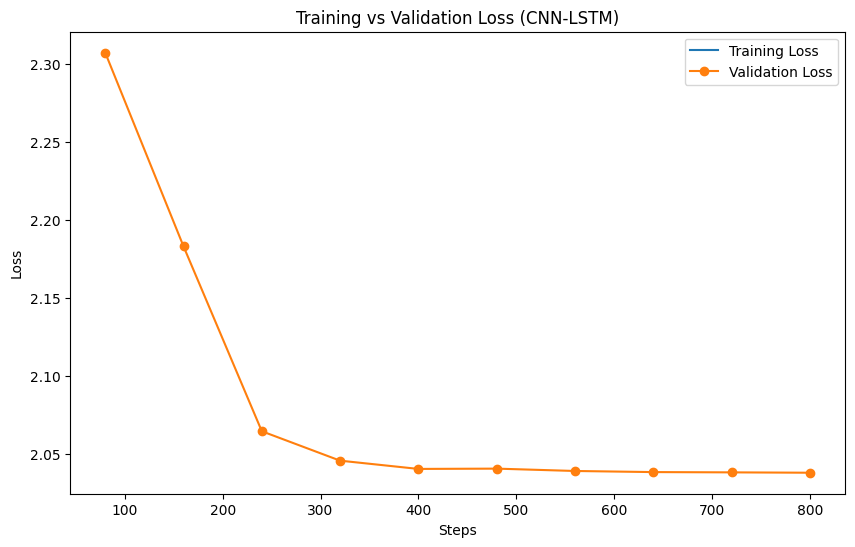

In [55]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (CNN-LSTM)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

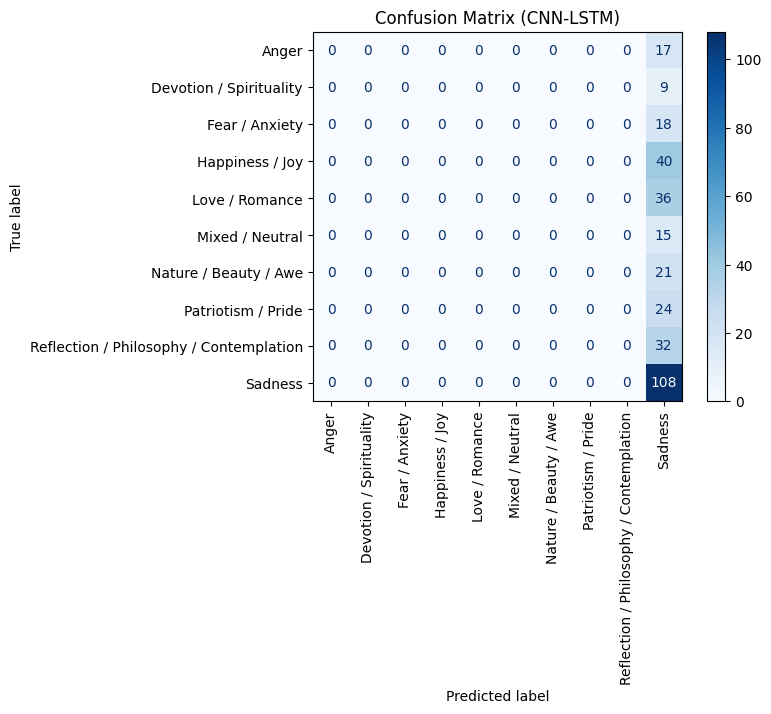

In [56]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (CNN-LSTM)')
plt.show()

In [57]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: DeBERTv3.ipynb

# DeBERTv3 for Hindi Poem Emotion Classification

**Model:** `microsoft/deberta-v3-base`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [58]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [59]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

Loaded 1600 samples, 10 classes


In [60]:
model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [61]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [62]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_deberta',
    num_train_epochs=5,
    per_device_train_batch_size=8, # Decrease batch for DeBERTa
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.047450542449951, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 6.7443, 'eval_samples_per_second': 47.448, 'eval_steps_per_second': 2.965, 'epoch': 1.0}


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.048224687576294, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 8.179, 'eval_samples_per_second': 39.125, 'eval_steps_per_second': 2.445, 'epoch': 2.0}


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0170369148254395, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 22.7082, 'eval_samples_per_second': 14.092, 'eval_steps_per_second': 0.881, 'epoch': 3.0}


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9790061712265015, 'eval_accuracy': 0.375, 'eval_f1': 0.23243279934835734, 'eval_precision': 0.173971241524433, 'eval_recall': 0.375, 'eval_runtime': 8.9094, 'eval_samples_per_second': 35.917, 'eval_steps_per_second': 2.245, 'epoch': 4.0}


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.982446312904358, 'eval_accuracy': 0.38125, 'eval_f1': 0.2380676445784672, 'eval_precision': 0.17385025116923608, 'eval_recall': 0.38125, 'eval_runtime': 8.2855, 'eval_samples_per_second': 38.622, 'eval_steps_per_second': 2.414, 'epoch': 5.0}
{'train_runtime': 675.3202, 'train_samples_per_second': 9.477, 'train_steps_per_second': 0.592, 'train_loss': 2.069460906982422, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.069460906982422, metrics={'train_runtime': 675.3202, 'train_samples_per_second': 9.477, 'train_steps_per_second': 0.592, 'total_flos': 421015476633600.0, 'train_loss': 2.069460906982422, 'epoch': 5.0})

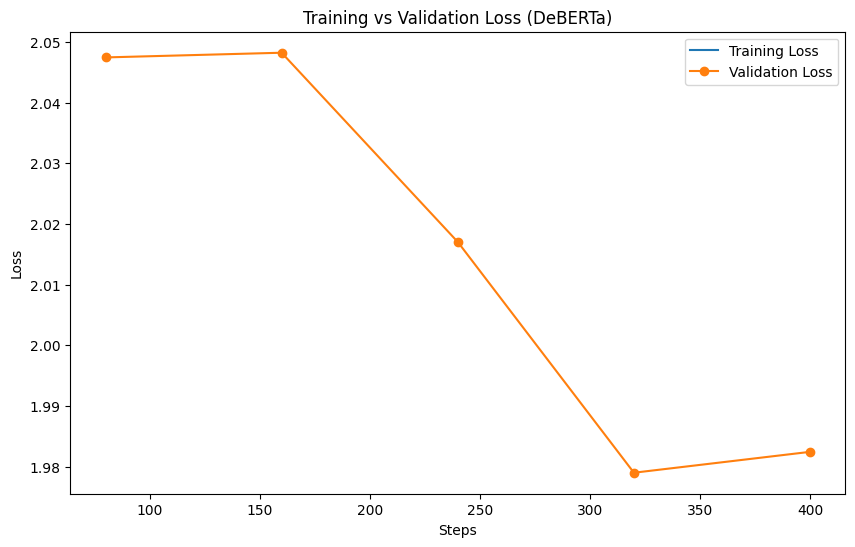

In [63]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (DeBERTa)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

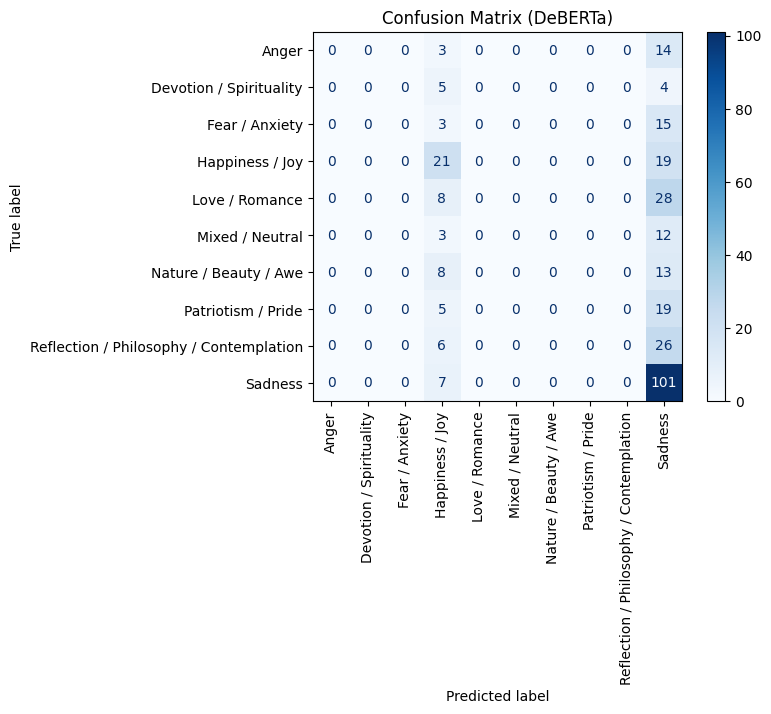

In [64]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (DeBERTa)')
plt.show()

In [65]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


Memory cleared.


# Model Experiment: DistilBERT.ipynb

# DistilBERT for Hindi Poem Emotion Classification

**Model:** `distilbert-base-multilingual-cased`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

Loaded 1600 samples, 10 classes


In [5]:
model_name = 'distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.059241771697998, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 1.5976, 'eval_samples_per_second': 200.302, 'eval_steps_per_second': 6.259, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.035311698913574, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 1.5892, 'eval_samples_per_second': 201.362, 'eval_steps_per_second': 6.293, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.028765916824341, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 1.6289, 'eval_samples_per_second': 196.452, 'eval_steps_per_second': 6.139, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 1.9521381855010986, 'eval_accuracy': 0.38125, 'eval_f1': 0.2378898603680021, 'eval_precision': 0.18304945054945057, 'eval_recall': 0.38125, 'eval_runtime': 1.6213, 'eval_samples_per_second': 197.369, 'eval_steps_per_second': 6.168, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.03096866607666, 'eval_accuracy': 0.30625, 'eval_f1': 0.25711659663865544, 'eval_precision': 0.24138742120875048, 'eval_recall': 0.30625, 'eval_runtime': 1.5769, 'eval_samples_per_second': 202.931, 'eval_steps_per_second': 6.342, 'epoch': 5.0}
{'train_runtime': 165.9575, 'train_samples_per_second': 38.564, 'train_steps_per_second': 2.41, 'train_loss': 2.0312445068359377, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.0312445068359377, metrics={'train_runtime': 165.9575, 'train_samples_per_second': 38.564, 'train_steps_per_second': 2.41, 'total_flos': 193761210240000.0, 'train_loss': 2.0312445068359377, 'epoch': 5.0})

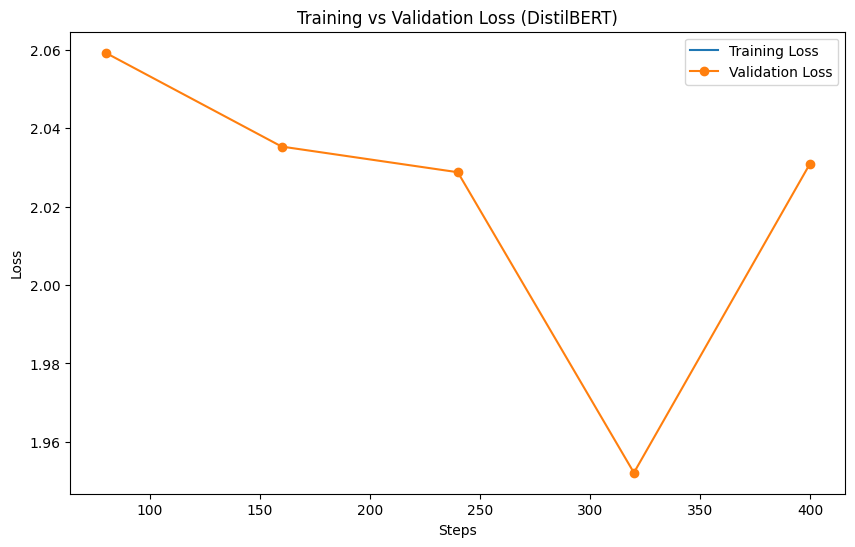

In [8]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (DistilBERT)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

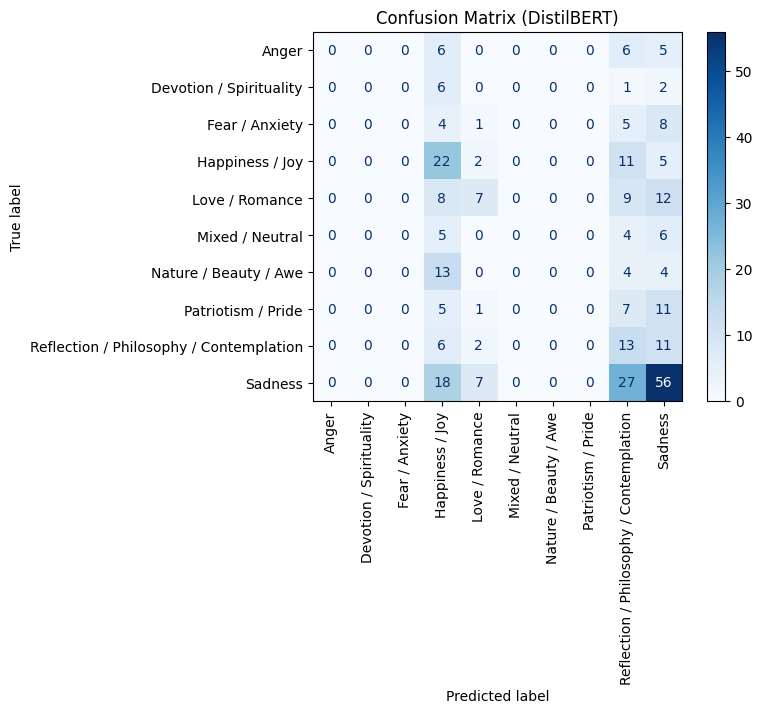

In [9]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (DistilBERT)')
plt.show()

In [10]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: Electra.ipynb

# Electra for Hindi Poem Emotion Classification

**Model:** `google/electra-small-discriminator`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [11]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

Loaded 1600 samples, 10 classes


In [13]:
model_name = 'google/electra-small-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_electra',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.2300705909729004, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.6639, 'eval_samples_per_second': 481.973, 'eval_steps_per_second': 15.062, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.1269335746765137, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.6222, 'eval_samples_per_second': 514.316, 'eval_steps_per_second': 16.072, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0633299350738525, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.6301, 'eval_samples_per_second': 507.877, 'eval_steps_per_second': 15.871, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.036804437637329, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.6383, 'eval_samples_per_second': 501.362, 'eval_steps_per_second': 15.668, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 2.0310585498809814, 'eval_accuracy': 0.3375, 'eval_f1': 0.1703271028037383, 'eval_precision': 0.11390625000000001, 'eval_recall': 0.3375, 'eval_runtime': 0.6403, 'eval_samples_per_second': 499.759, 'eval_steps_per_second': 15.617, 'epoch': 5.0}
{'train_runtime': 61.2347, 'train_samples_per_second': 104.516, 'train_steps_per_second': 6.532, 'train_loss': 2.1342646789550783, 'epoch': 5.0}


TrainOutput(global_step=400, training_loss=2.1342646789550783, metrics={'train_runtime': 61.2347, 'train_samples_per_second': 104.516, 'train_steps_per_second': 6.532, 'total_flos': 47081530982400.0, 'train_loss': 2.1342646789550783, 'epoch': 5.0})

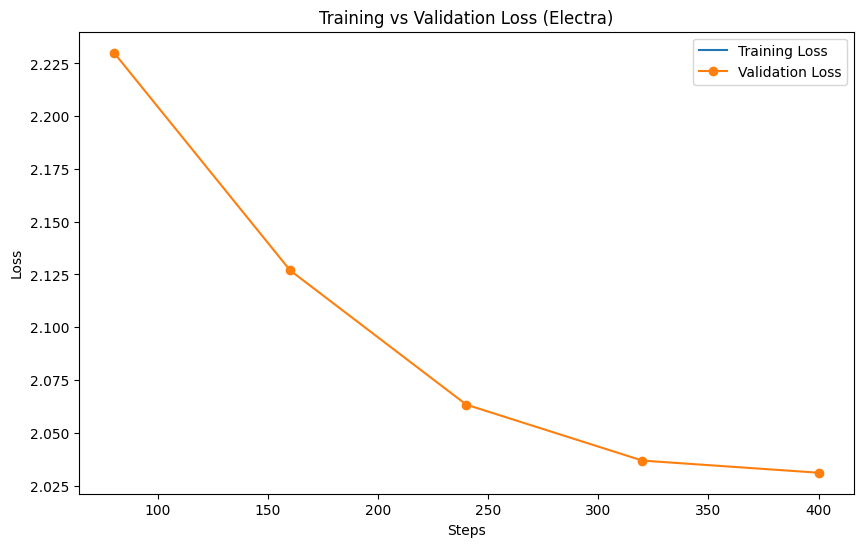

In [16]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (Electra)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 1200x1000 with 0 Axes>

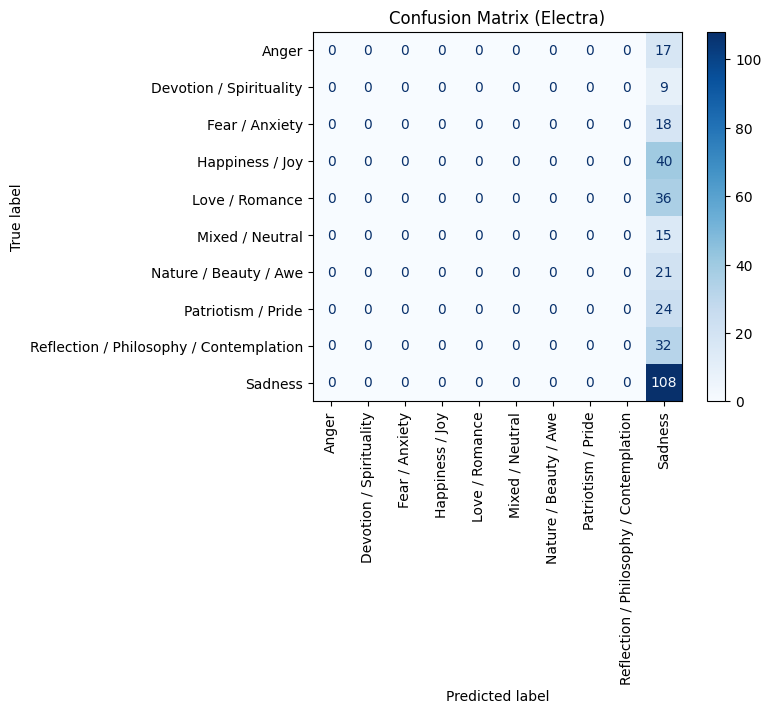

In [17]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Electra)')
plt.show()

In [18]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: IndicBERT + DAPT + Hierarchical Attention.ipynb

# IndicBERT + DAPT + Hierarchical Attention

**Model:** `ai4bharat/indic-bert` (with DAPT fallback)
**Architecture:** Hierarchical Attention Network (Word -> Verse -> Poem)
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MODEL_NAME = "ai4bharat/indic-bert"
DAPT_PATH = "./indicbert_dapt"
MAX_VERSES = 10
MAX_LEN = 64
BATCH_SIZE = 4
EPOCHS = 5
LR = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [20]:
# Load Data
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'
    
if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    NUM_CLASSES = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {NUM_CLASSES} classes")
else:
    print("Dataset not found.")
    # Fallback/Dummy data for robustness check if running without file
    texts = ["This is a test poem.\nLine 2.\nLine 3."] * 10
    labels = [0] * 10
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    NUM_CLASSES = 1

Loaded 1600 samples, 10 classes


In [21]:
# Determine Model Path (DAPT if exists, else Base)
use_model = DAPT_PATH if os.path.exists(DAPT_PATH) else MODEL_NAME
print(f"Loading model from: {use_model}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Tokenizer is always from base for compatibility usually
encoder = AutoModel.from_pretrained(use_model)

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.linear(x))
        scores = self.context(u).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        output = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return output, weights

# HAN Model
class IndicBERT_HAN(nn.Module):
    def __init__(self, bert, hidden_dim, num_classes):
        super().__init__()
        self.bert = bert
        self.attention = AttentionLayer(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch, verses, seq_len)
        b, v, l = input_ids.size()
        input_ids = input_ids.view(-1, l)
        attention_mask = attention_mask.view(-1, l)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0]
        cls_embeddings = cls_embeddings.view(b, v, -1)

        poem_embedding, attn_weights = self.attention(cls_embeddings)
        poem_embedding = self.dropout(poem_embedding)

        logits = self.classifier(poem_embedding)
        return logits, attn_weights

# Dataset
class PoetryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def tokenize_poem(self, poem):
        verses = str(poem).split("\n")[:MAX_VERSES]
        encodings = []
        for v in verses:
            if not v.strip(): continue
            enc = self.tokenizer(
                v, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt"
            )
            encodings.append(enc)

        # Padding if verses < MAX_VERSES
        while len(encodings) < MAX_VERSES:
            encodings.append(
                self.tokenizer("", padding="max_length", max_length=MAX_LEN, return_tensors="pt")
            )
        
        input_ids = torch.cat([e["input_ids"] for e in encodings])
        attention_mask = torch.cat([e["attention_mask"] for e in encodings])
        return input_ids, attention_mask

    def __getitem__(self, idx):
        poem = self.texts[idx]
        label = self.labels[idx]
        input_ids, attention_mask = self.tokenize_poem(poem)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label)
        }

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoetryDataset(train_texts, train_labels, tokenizer)
val_dataset = PoetryDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Init Model
model = IndicBERT_HAN(encoder, hidden_dim=768, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Loading model from: ai4bharat/indic-bert


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
# Training
history = {'train_loss': [], 'val_f1': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss/len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits, _ = model(input_ids, attention_mask)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            gold.extend(labels.cpu().numpy())
    
    f1 = precision_recall_fscore_support(gold, preds, average='weighted')[2]
    acc = accuracy_score(gold, preds)
    history['val_f1'].append(f1)
    history['val_acc'].append(acc)
    print(f"Epoch {epoch+1} | Val F1: {f1:.4f} | Val Acc: {acc:.4f}")

Epoch 1: 100%|██████████| 320/320 [08:19<00:00,  1.56s/it]


Epoch 1 | Train Loss: 2.1026


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 | Val F1: 0.1703 | Val Acc: 0.3375


Epoch 2: 100%|██████████| 320/320 [07:50<00:00,  1.47s/it]


Epoch 2 | Train Loss: 2.0556


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 2 | Val F1: 0.1703 | Val Acc: 0.3375


Epoch 3: 100%|██████████| 320/320 [07:36<00:00,  1.43s/it]


Epoch 3 | Train Loss: 2.0527


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 3 | Val F1: 0.1703 | Val Acc: 0.3375


Epoch 4: 100%|██████████| 320/320 [07:28<00:00,  1.40s/it]


Epoch 4 | Train Loss: 2.0532


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 4 | Val F1: 0.1703 | Val Acc: 0.3375


Epoch 5: 100%|██████████| 320/320 [07:30<00:00,  1.41s/it]


Epoch 5 | Train Loss: 2.0392
Epoch 5 | Val F1: 0.1703 | Val Acc: 0.3375


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


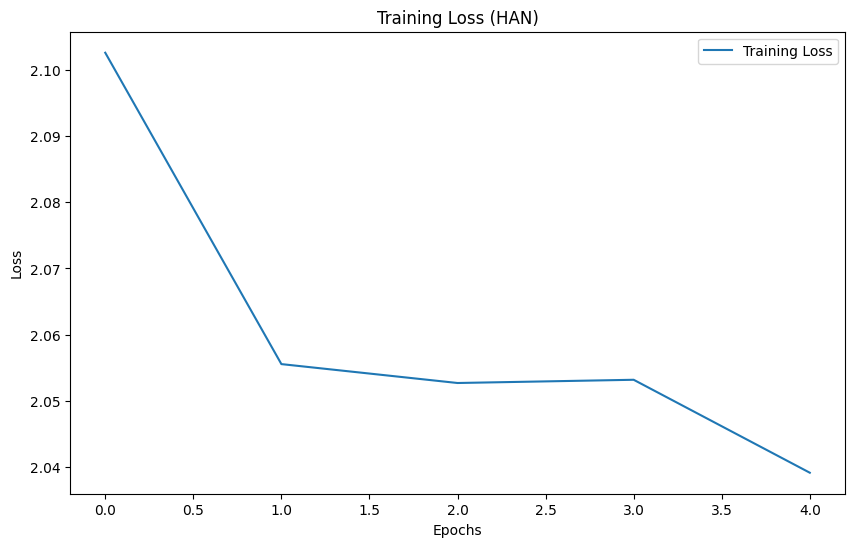

<Figure size 1200x1000 with 0 Axes>

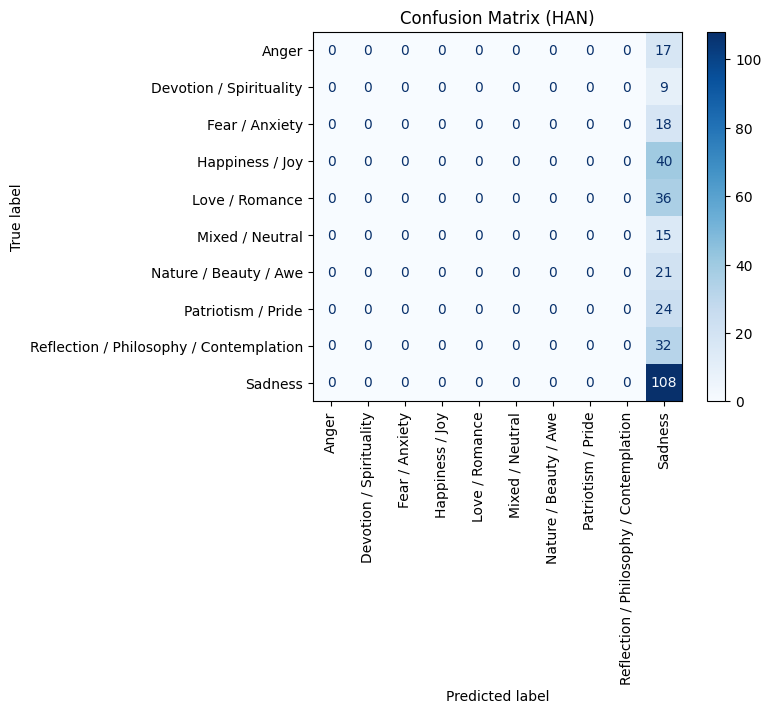

In [23]:
# Visualizations
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
# Note: Validation Loss isn't tracked in above loop, usually nice to have. 
# But F1/Acc is plotted here.
plt.title('Training Loss (HAN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
cm = confusion_matrix(gold, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (HAN)')
plt.show()

In [24]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: MuRIL + DAPT + Hierarchical Attention.ipynb

# MuRIL + DAPT + Hierarchical Attention

**Model:** `google/muril-base-cased` (with DAPT fallback)
**Architecture:** Hierarchical Attention Network (Word -> Verse -> Poem)
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MODEL_NAME = "google/muril-base-cased"
DAPT_PATH = "./muril_dapt"
MAX_VERSES = 10
MAX_LEN = 64
BATCH_SIZE = 4
EPOCHS = 5
LR = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [26]:
# Load Data
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'
    
if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    NUM_CLASSES = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {NUM_CLASSES} classes")
else:
    print("Dataset not found.")
    # Fallback/Dummy data for robustness check if running without file
    texts = ["This is a test poem.\nLine 2.\nLine 3."] * 10
    labels = [0] * 10
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    NUM_CLASSES = 1

Loaded 1600 samples, 10 classes


In [27]:
# Determine Model Path (DAPT if exists, else Base)
use_model = DAPT_PATH if os.path.exists(DAPT_PATH) else MODEL_NAME
print(f"Loading model from: {use_model}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = AutoModel.from_pretrained(use_model)

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.linear(x))
        scores = self.context(u).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        output = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return output, weights

# HAN Model
class MuRIL_HAN(nn.Module):
    def __init__(self, bert, hidden_dim, num_classes):
        super().__init__()
        self.bert = bert
        self.attention = AttentionLayer(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch, verses, seq_len)
        b, v, l = input_ids.size()
        input_ids = input_ids.view(-1, l)
        attention_mask = attention_mask.view(-1, l)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # MuRIL's pooler output or CLS? Using last_hidden_state CLS
        cls_embeddings = outputs.last_hidden_state[:, 0]
        cls_embeddings = cls_embeddings.view(b, v, -1)

        poem_embedding, attn_weights = self.attention(cls_embeddings)
        poem_embedding = self.dropout(poem_embedding)

        logits = self.classifier(poem_embedding)
        return logits, attn_weights

# Dataset
class PoetryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def tokenize_poem(self, poem):
        verses = str(poem).split("\n")[:MAX_VERSES]
        encodings = []
        for v in verses:
            if not v.strip(): continue
            enc = self.tokenizer(
                v, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt"
            )
            encodings.append(enc)

        # Padding if verses < MAX_VERSES
        while len(encodings) < MAX_VERSES:
            encodings.append(
                self.tokenizer("", padding="max_length", max_length=MAX_LEN, return_tensors="pt")
            )
        
        input_ids = torch.cat([e["input_ids"] for e in encodings])
        attention_mask = torch.cat([e["attention_mask"] for e in encodings])
        return input_ids, attention_mask

    def __getitem__(self, idx):
        poem = self.texts[idx]
        label = self.labels[idx]
        input_ids, attention_mask = self.tokenize_poem(poem)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label)
        }

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoetryDataset(train_texts, train_labels, tokenizer)
val_dataset = PoetryDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Init Model
model = MuRIL_HAN(encoder, hidden_dim=768, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Loading model from: google/muril-base-cased


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
# Training
history = {'train_loss': [], 'val_f1': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss/len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits, _ = model(input_ids, attention_mask)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            gold.extend(labels.cpu().numpy())
    
    f1 = precision_recall_fscore_support(gold, preds, average='weighted')[2]
    acc = accuracy_score(gold, preds)
    history['val_f1'].append(f1)
    history['val_acc'].append(acc)
    print(f"Epoch {epoch+1} | Val F1: {f1:.4f} | Val Acc: {acc:.4f}")

Epoch 1: 100%|██████████| 320/320 [09:46<00:00,  1.83s/it]


Epoch 1 | Train Loss: 2.2362


/Users/hemishjain22/anaconda3/envs/main_nlp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1 | Val F1: 0.1703 | Val Acc: 0.3375


Epoch 2:  52%|█████▏    | 167/320 [05:12<04:46,  1.87s/it]


KeyboardInterrupt: 

In [ ]:
# Visualizations
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.title('Training Loss (MuRIL HAN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
cm = confusion_matrix(gold, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (MuRIL HAN)')
plt.show()

In [ ]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: SpanBERT.ipynb

# SpanBERT for Hindi Poem Emotion Classification

**Model:** `SpanBERT/spanbert-base-cased`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

In [ ]:
model_name = 'SpanBERT/spanbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_spanbert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (SpanBERT)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (SpanBERT)')
plt.show()

In [ ]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: XLNET.ipynb

# XLNET for Hindi Poem Emotion Classification

**Model:** `xlnet-base-cased`
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Load Dataset
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    num_labels = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {num_labels} classes")
else:
    print("Dataset not found.")

In [ ]:
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

class PoemDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    encodings['attention_mask'], test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoemDataset({'input_ids': train_inputs, 'attention_mask': train_masks}, train_labels)
val_dataset = PoemDataset({'input_ids': val_inputs, 'attention_mask': val_masks}, val_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results_xlnet',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
log_history = trainer.state.log_history
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (XLNET)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
cm = confusion_matrix(val_labels, preds, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (XLNET)')
plt.show()

In [ ]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed


# Model Experiment: mBERT + DAPT + Hierarchical Attention.ipynb

# mBERT + DAPT + Hierarchical Attention

**Model:** `bert-base-multilingual-cased` (with DAPT fallback)
**Architecture:** Hierarchical Attention Network (Word -> Verse -> Poem)
**Dataset:** `Final_hindi_dataset_with_emotions_categorized.xlsx`


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
MODEL_NAME = "bert-base-multilingual-cased"
DAPT_PATH = "./mbert_dapt"
MAX_VERSES = 10
MAX_LEN = 64
BATCH_SIZE = 4
EPOCHS = 5
LR = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

In [ ]:
# Load Data
file_path = '../Final_hindi_dataset_with_emotions_categorized.xlsx'
if not os.path.exists(file_path):
    file_path = 'Final_hindi_dataset_with_emotions_categorized.xlsx'
    
if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    df = df.dropna(subset=['poem_text', 'dominant_category'])
    df = df.groupby('dominant_category').filter(lambda x: len(x) > 1)
    texts = df['poem_text'].tolist()
    labels_raw = df['dominant_category'].tolist()
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels_raw)
    NUM_CLASSES = len(label_encoder.classes_)
    print(f"Loaded {len(df)} samples, {NUM_CLASSES} classes")
else:
    print("Dataset not found.")
    # Fallback/Dummy data for robustness check if running without file
    texts = ["This is a test poem.\nLine 2.\nLine 3."] * 10
    labels = [0] * 10
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    NUM_CLASSES = 1

In [ ]:
# Determine Model Path (DAPT if exists, else Base)
use_model = DAPT_PATH if os.path.exists(DAPT_PATH) else MODEL_NAME
print(f"Loading model from: {use_model}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = AutoModel.from_pretrained(use_model)

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        u = torch.tanh(self.linear(x))
        scores = self.context(u).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        output = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return output, weights

# HAN Model
class mBERT_HAN(nn.Module):
    def __init__(self, bert, hidden_dim, num_classes):
        super().__init__()
        self.bert = bert
        self.attention = AttentionLayer(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch, verses, seq_len)
        b, v, l = input_ids.size()
        input_ids = input_ids.view(-1, l)
        attention_mask = attention_mask.view(-1, l)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0]
        cls_embeddings = cls_embeddings.view(b, v, -1)

        poem_embedding, attn_weights = self.attention(cls_embeddings)
        poem_embedding = self.dropout(poem_embedding)

        logits = self.classifier(poem_embedding)
        return logits, attn_weights

# Dataset
class PoetryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def tokenize_poem(self, poem):
        verses = str(poem).split("\n")[:MAX_VERSES]
        encodings = []
        for v in verses:
            if not v.strip(): continue
            enc = self.tokenizer(
                v, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt"
            )
            encodings.append(enc)

        # Padding if verses < MAX_VERSES
        while len(encodings) < MAX_VERSES:
            encodings.append(
                self.tokenizer("", padding="max_length", max_length=MAX_LEN, return_tensors="pt")
            )
        
        input_ids = torch.cat([e["input_ids"] for e in encodings])
        attention_mask = torch.cat([e["attention_mask"] for e in encodings])
        return input_ids, attention_mask

    def __getitem__(self, idx):
        poem = self.texts[idx]
        label = self.labels[idx]
        input_ids, attention_mask = self.tokenize_poem(poem)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label)
        }

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PoetryDataset(train_texts, train_labels, tokenizer)
val_dataset = PoetryDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Init Model
model = mBERT_HAN(encoder, hidden_dim=768, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training
history = {'train_loss': [], 'val_f1': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss/len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits, _ = model(input_ids, attention_mask)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            gold.extend(labels.cpu().numpy())
    
    f1 = precision_recall_fscore_support(gold, preds, average='weighted')[2]
    acc = accuracy_score(gold, preds)
    history['val_f1'].append(f1)
    history['val_acc'].append(acc)
    print(f"Epoch {epoch+1} | Val F1: {f1:.4f} | Val Acc: {acc:.4f}")

In [ ]:
# Visualizations
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.title('Training Loss (mBERT HAN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
cm = confusion_matrix(gold, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (mBERT HAN)')
plt.show()

In [ ]:
# --- Memory Cleanup after Experiment ---
try:
    del model
    del trainer
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleared.")
except NameError:
    pass # specific variables might not exist if run failed
